In this technical lesson, we'll walk through the process of building a text classification model using Naive Bayes, extending our approach to include word embeddings for comparison with traditional vectorization techniques. We'll follow the established process of:

1. problem definition
2. preprocessing
3. feature extraction
4. model selection
5. training, and evaluation

Customer support departments often receive hundreds or thousands of tickets daily that need to be routed to the correct team. Manually sorting these tickets is time-consuming and prone to error. By automating this classification process, we can significantly reduce response times and ensure that customer issues are handled by the right specialists.

We'll implement a Multinomial Naive Bayes classifier, which is particularly well-suited for text classification tasks due to its ability to work with the discrete features created by text vectorization. 

We'll also explore how modern word embeddings can provide an alternative feature representation that captures semantic relationships between words. 

Throughout this lesson, you'll learn how to transform raw text into numerical features using different approaches and build probabilistic models that can automatically categorize new text based on patterns learned from labeled examples.

##### Step 1: Problem Definition and Dataset Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import gensim.downloader as api
from gensim.models import Word2Vec

In [2]:
df = pd.read_csv('customer_support_ticket.csv')
df.head()

,ticket_id,ticket_text,department
0,1,Cannot login to my account after password reset,technical
1,2,The website is loading very slowly on my browser,technical
2,3,The app crashes whenever I try to upload photos,technical
3,4,Videos are not playing properly on my device,technical
4,5,The checkout process gave me an error,technical


In [3]:
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['department'].value_counts())
print("\nSample tickets per department:")
for dept in df['department'].unique():
    sample_idx = df[df['department'] == dept].index[0]
    print(f"\n{dept.upper()}: {df.loc[sample_idx, 'ticket_text']}")

Dataset shape: (90, 3)

Class distribution:
department
technical    30
account      30
billing      30
Name: count, dtype: int64

Sample tickets per department:

TECHNICAL: Cannot login to my account after password reset

ACCOUNT: How do I update my shipping address for my order?

BILLING: My payment was charged twice for one order


##### Step 2: Text Preprocessing

In [8]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Lemmatizer relies of part of speech to help
def get_wordnet_pos(treebank_tag):
  '''
  Translate nltk POS to wordnet tags
  '''
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN


def basic_preprocess(text):
   """Basic preprocessing function for text."""
   # Convert to lowercase
   text = text.lower()
  
   # Remove special characters and numbers
   text = re.sub(r'[^a-zA-Z\s]', '', text)
  
   # Return cleaned text
   return text


def advanced_preprocess(text):
   """Advanced preprocessing with tokenization, stopword removal, and lemmatization."""
   # Basic cleaning
   text = basic_preprocess(text)
  
   # Tokenize
   tokens = nltk.word_tokenize(text)
  
   # Tag with pos
   tokens_tagged = pos_tag(tokens)
   pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
  
   # Remove stopwords and lemmatize
   cleaned_tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in pos_tokens if token[0] not in stop_words and len(token[0]) > 1]
  
   # Return cleaned tokens
   return ' '.join(cleaned_tokens)


# Apply preprocessing to the dataset
df['cleaned_text'] = df['ticket_text'].apply(basic_preprocess)
df['lemmatized_text'] = df['ticket_text'].apply(advanced_preprocess)


# Show the preprocessing results for a sample ticket
sample_idx = 1
print(f"Original: {df.loc[sample_idx, 'ticket_text']}")
print(f"Cleaned: {df.loc[sample_idx, 'cleaned_text']}")
print(f"Lemmatized: {df.loc[sample_idx, 'lemmatized_text']}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original: The website is loading very slowly on my browser
Cleaned: the website is loading very slowly on my browser
Lemmatized: website load slowly browser


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
   df['ticket_text'],
   df['department'],
   test_size=0.3,
   random_state=42,
   stratify=df['department']  # Ensure balanced classes in both sets
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Class distribution in testing set: \n{y_test.value_counts()}")

Training set size: 63
Testing set size: 27
Class distribution in training set: 
department
technical    21
account      21
billing      21
Name: count, dtype: int64
Class distribution in testing set: 
department
account      9
technical    9
billing      9
Name: count, dtype: int64


##### Step 3: Feature Extraction

In [10]:
# Bag of Words vectorizer
count_vectorizer = CountVectorizer(
   preprocessor=advanced_preprocess,
   lowercase=False,  # Already done in preprocessing
   min_df=2,  # Ignore terms that appear in fewer than 2 documents
   max_df=0.95, # Ignore terms that appear in more than 95% of documents
   ngram_range=(1, 2) # Include both single words and pairs of consecutive words
)

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
   preprocessor=advanced_preprocess,
   lowercase=False,
   min_df=2,
   max_df=0.95,
   ngram_range=(1, 2)
)

# Apply vectorizers to training data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Get feature information
count_features = count_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print(f"Bag of Words features: {len(count_features)}")
print(f"TF-IDF features: {len(tfidf_features)}")
print(f"Sample BoW features: {count_features[:10]}")
print(f"Sample TF-IDF features (including bigrams): {[f for f in tfidf_features[:20] if ' ' in f][:5]}")

Bag of Words features: 57
TF-IDF features: 57
Sample BoW features: ['access' 'account' 'account password' 'account show' 'add' 'address'
 'app' 'billing' 'browser' 'change']
Sample TF-IDF features (including bigrams): ['account password', 'account show', 'get error']


In [12]:
# Create a list of tokens from the lemmatize text
df['tokens'] = df['lemmatized_text'].apply(lambda x: x.split())

# Train a Word2Vec model on our dataset
# Note: In a real-world scenario, you'd use a much larger corpus
# or pre-trained embeddings for better results

w2v_model = Word2Vec(
   df['tokens'],
   vector_size=100,  # Dimension of the embedding vectors
   window=5,  # Context window size
   min_count=1,  # Ignore words with fewer occurrences
   workers=4,  # Number of processors to use
   sg=1  # Skip-gram model (1) instead of CBOW (0)
)

# Function to create document vectors by averaging word vectors
def document_to_vector(tokens, model, vector_size=100):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)
  
   # Count valid tokens
   valid_token_count = 0
  
   # Sum up vectors for each token
   for token in tokens:
       if token in model.wv:
           doc_vector += model.wv[token]
           valid_token_count += 1
  
   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count
      
   return doc_vector


def document_to_vector_pretrained(tokens, model, vector_size=300):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)
  
   # Count valid tokens
   valid_token_count = 0
  
   # Sum up vectors for each token
   for token in tokens:
       if token in model:
           doc_vector += model[token]
           valid_token_count += 1
  
   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count
      
   return doc_vector

X_train_tokens = df.loc[X_train.index, 'tokens']
X_test_tokens = df.loc[X_test.index, 'tokens']

# Create document vectors for training and test sets
X_train_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_test_tokens])


print(f"Word2Vec document vectors shape: {X_train_w2v.shape}")


# Alternatively, download and use pre-trained embeddings
# This takes more time but might give better results
try:
   # Attempt to download pre-trained embeddings (if internet is available)
   pretrained_model = api.load('word2vec-google-news-300')
   print("Pre-trained model loaded successfully.")
  
   # Create vectors using pre-trained embeddings
   X_train_pretrained = np.array([document_to_vector_pretrained(tokens, pretrained_model, 300)
                                   for tokens in X_train_tokens])
   X_test_pretrained = np.array([document_to_vector_pretrained(tokens, pretrained_model, 300)
                                  for tokens in X_test_tokens])
  
   print(f"Pre-trained document vectors shape: {X_train_pretrained.shape}")
   pretrained_available = True
except Exception as e:
   print(f"Pre-trained embeddings could not be loaded: {e}")
   pretrained_available = False

Word2Vec document vectors shape: (63, 100)
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Pre-trained model loaded successfully.
Pre-trained document vectors shape: (63, 300)


##### Step 5: Model Selection and Training

In [13]:
# Train with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)


# Train with TF-IDF features
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)


# For Word2Vec features, we need to convert the data to a non-negative representation
# because Multinomial NB requires non-negative feature values
# One simple approach is min-max scaling
def min_max_scale(X):
   """Scale features to [0, 1] range."""
   X_min = X.min(axis=0)
   X_max = X.max(axis=0)
   return (X - X_min) / (X_max - X_min + 1e-10)  # Adding a small epsilon to avoid division by zero


X_train_w2v_scaled = min_max_scale(X_train_w2v)
X_test_w2v_scaled = min_max_scale(X_test_w2v)


# Train with Word2Vec features
nb_w2v = MultinomialNB(alpha=1.0)
nb_w2v.fit(X_train_w2v_scaled, y_train)


# Also train with pre-trained embeddings if available
if pretrained_available:
   X_train_pretrained_scaled = min_max_scale(X_train_pretrained)
   X_test_pretrained_scaled = min_max_scale(X_test_pretrained)
  
   nb_pretrained = MultinomialNB(alpha=1.0)
   nb_pretrained.fit(X_train_pretrained_scaled, y_train)

In [15]:
# Function to display top features by class
def display_top_features(classifier, vectorizer, class_labels, n=10):
   """Display the top n words for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   for i, class_label in enumerate(class_labels):
       top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:][::-1]
       top_features = [feature_names[j] for j in top_indices]
       print(f"\nTop words for '{class_label}':")
       print(", ".join(top_features))


# Display top features for Bag of Words model
print("\nTop discriminative features per department (Bag of Words model):")
display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)


# Display top features for BoW model, focusing on bigrams
print("\nTop discriminative bigrams per department (Bag of Words model):")
def display_top_ngrams(classifier, vectorizer, class_labels, n=5):
   """Display the top n bigrams for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   # Get indices of all bigram features
   bigram_indices = [i for i, feat in enumerate(feature_names) if ' ' in feat]
  
   for i, class_label in enumerate(class_labels):
       # Filter to only consider bigram features
       bigram_log_probs = [(j, classifier.feature_log_prob_[i][j]) for j in bigram_indices]
       # Sort by probability (highest first)
       top_bigram_indices = sorted(bigram_log_probs, key=lambda x: x[1], reverse=True)[:n]
       top_bigrams = [feature_names[j] for j, _ in top_bigram_indices]
       print(f"\nTop bigrams for '{class_label}':")
       print(", ".join(top_bigrams))


display_top_ngrams(nb_bow, count_vectorizer, nb_bow.classes_)


Top discriminative features per department (Bag of Words model):

Top words for 'account':
need, account, change, update, preference, help, need help, need update, order, find

Top words for 'billing':
charge, need, payment, update, account, show, refund, method, fee, need update

Top words for 'technical':
website, error, load, account, checkout, get, access, phone, app, product

Top discriminative bigrams per department (Bag of Words model):

Top bigrams for 'account':
need help, need update, like change, would like, account password

Top bigrams for 'billing':
need update, payment method, account show, account password, get error

Top bigrams for 'technical':
get error, website load, account password, account show, show incorrect


Visualizing word embeddings for department-specific terms:


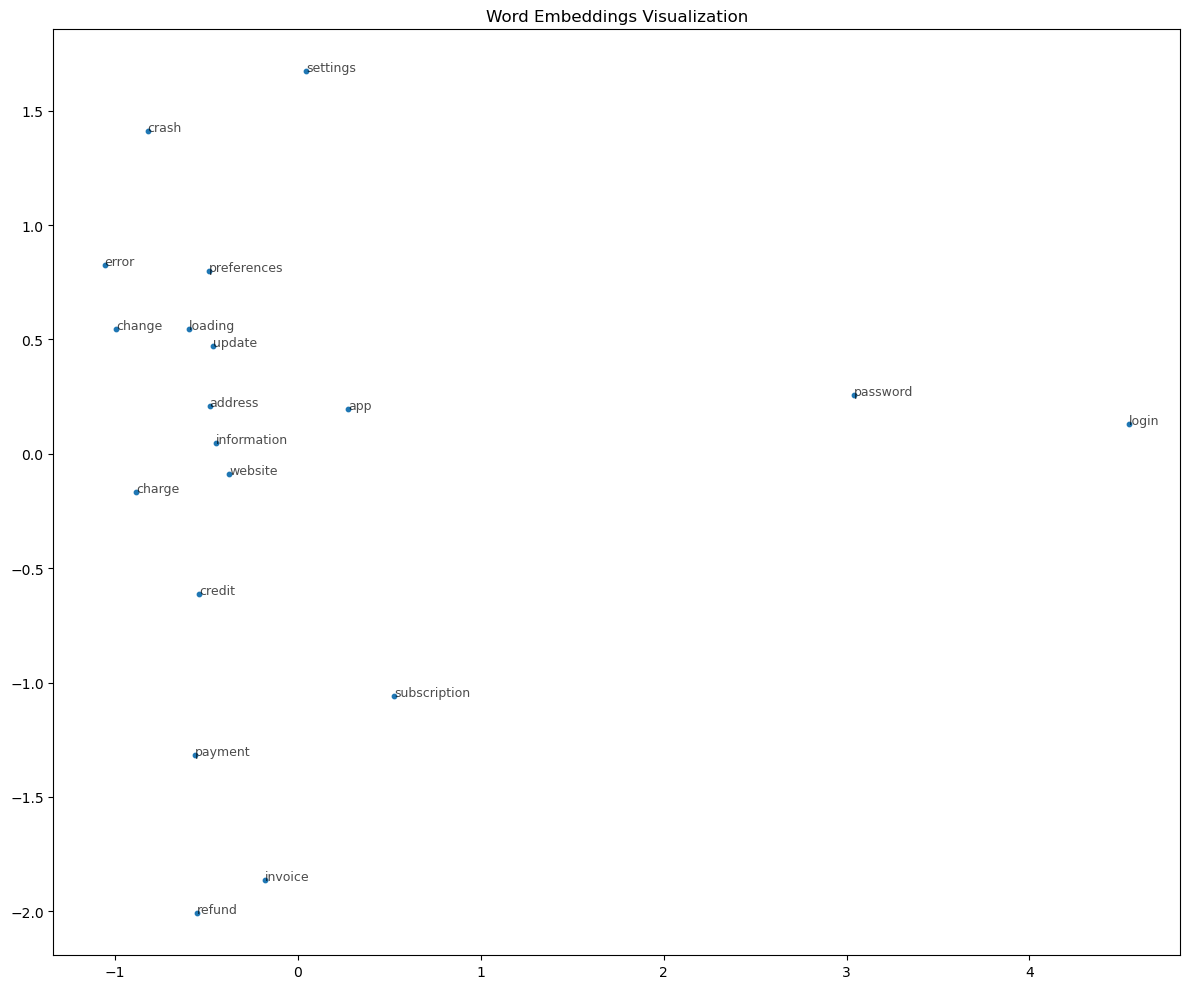

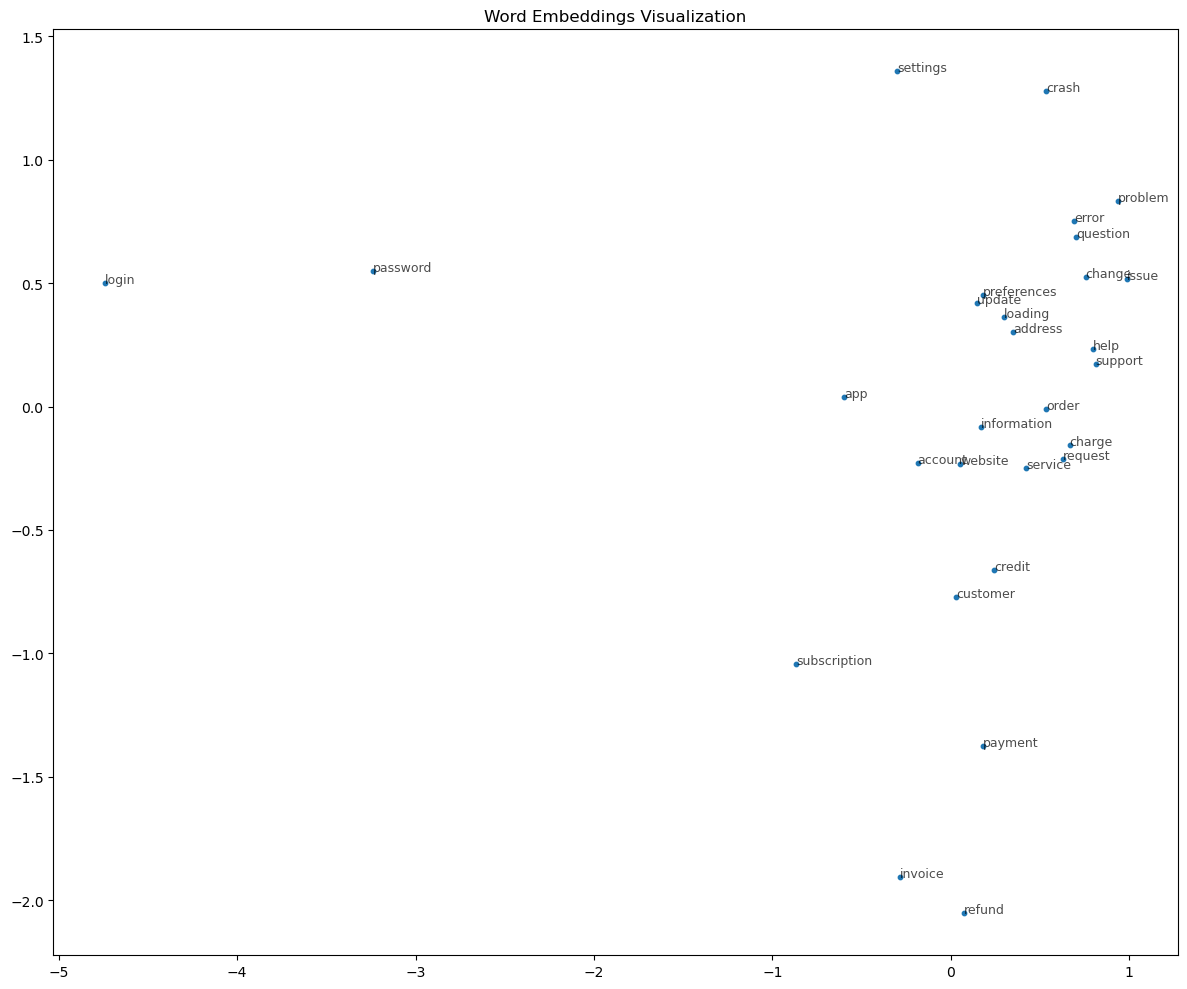

In [16]:
from sklearn.decomposition import PCA

# Function to visualize word embeddings in 2D
def visualize_embeddings(model, words=None, n=50):
   """Visualize word embeddings in a 2D space."""
   # If no specific words provided, use most frequent words
   if words is None:
       # Get word counts from the corpus
       from collections import Counter
       all_words = [word for doc in df['tokenized_text'] for word in doc]
       word_counts = Counter(all_words)
       words = [word for word, count in word_counts.most_common(n)]
  
   # Filter for words in the model's vocabulary
   valid_words = [word for word in words if word in model]
  
   if len(valid_words) == 0:
       print("No valid words found in model vocabulary!")
       return
  
   # Get word vectors
   word_vectors = [model[word] for word in valid_words]
  
   # Reduce to 2 dimensions with PCA
   pca = PCA(n_components=2)
   reduced_vectors = pca.fit_transform(word_vectors)
  
   # Plot the words in 2D space
   plt.figure(figsize=(12, 10))
   plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], s=10)
  
   # Add word labels
   for i, word in enumerate(valid_words):
       plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                   fontsize=9, alpha=0.7)
  
   plt.title('Word Embeddings Visualization')
   plt.tight_layout()
   plt.show()


# Visualize embeddings for department-specific words
department_words = {
   'technical': ['login', 'password', 'error', 'crash', 'app', 'loading', 'website'],
   'account': ['update', 'change', 'information', 'address', 'settings', 'preferences'],
   'billing': ['payment', 'charge', 'refund', 'credit', 'invoice', 'subscription']
}


# Flatten the word list
all_dept_words = [word for words in department_words.values() for word in words]


# Visualize the embeddings
print("Visualizing word embeddings for department-specific terms:")
visualize_embeddings(pretrained_model, all_dept_words)


# Also visualize some general support terms to see relationships
general_terms = ['help', 'issue', 'problem', 'support', 'request', 'question',
               'account', 'order', 'customer', 'service']
visualize_embeddings(pretrained_model, general_terms + all_dept_words)

##### Step 5: Model Evaluation

In [17]:
# Transform test data using the fitted vectorizers
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# Word2Vec test data was already prepared above


# Predict with Bag of Words model
y_pred_bow = nb_bow.predict(X_test_counts)


# Predict with TF-IDF model
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)


# Predict with Word2Vec model
y_pred_w2v = nb_w2v.predict(X_test_w2v_scaled)


# Predict with pre-trained embeddings if available
y_pred_pretrained = nb_pretrained.predict(X_test_pretrained_scaled)


Bag of Words Model Performance:
Accuracy: 0.5926

Classification Report:
              precision    recall  f1-score   support

     account       0.44      0.78      0.56         9
     billing       0.67      0.44      0.53         9
   technical       1.00      0.56      0.71         9

    accuracy                           0.59        27
   macro avg       0.70      0.59      0.60        27
weighted avg       0.70      0.59      0.60        27



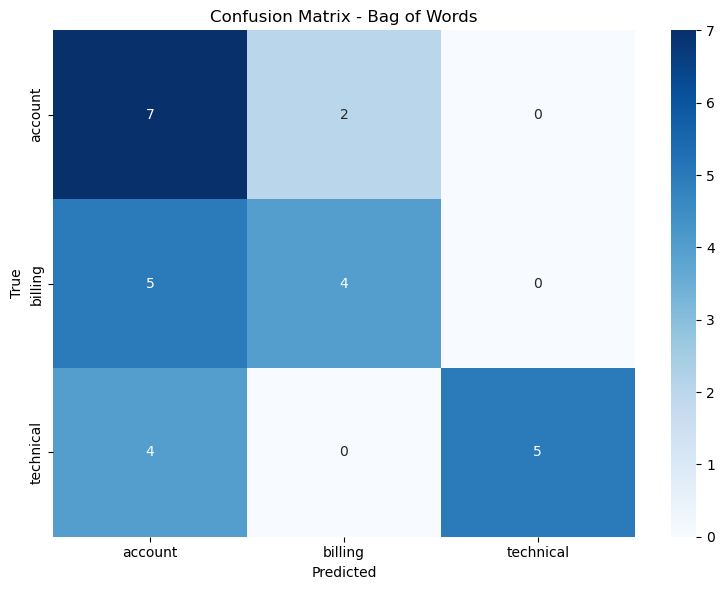


TF-IDF Model Performance:
Accuracy: 0.5926

Classification Report:
              precision    recall  f1-score   support

     account       0.44      0.89      0.59         9
     billing       0.80      0.44      0.57         9
   technical       1.00      0.44      0.62         9

    accuracy                           0.59        27
   macro avg       0.75      0.59      0.59        27
weighted avg       0.75      0.59      0.59        27



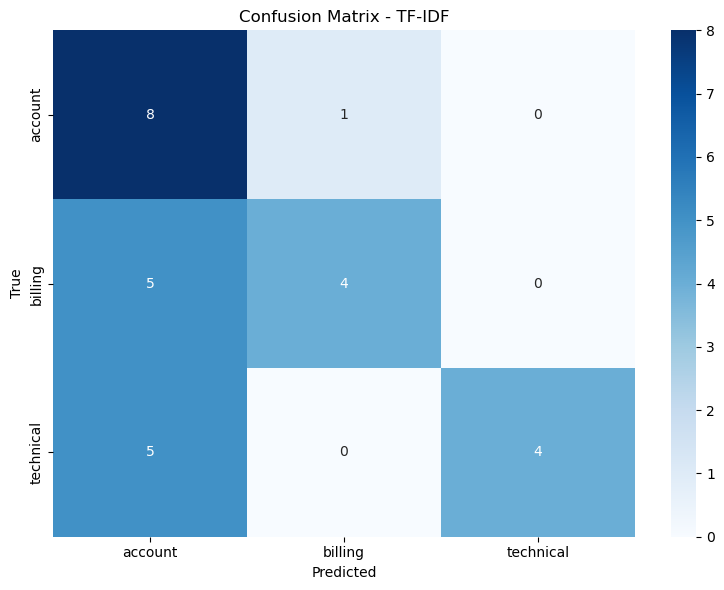


Word2Vec Model Performance:
Accuracy: 0.6296

Classification Report:
              precision    recall  f1-score   support

     account       0.64      0.78      0.70         9
     billing       0.50      0.56      0.53         9
   technical       0.83      0.56      0.67         9

    accuracy                           0.63        27
   macro avg       0.66      0.63      0.63        27
weighted avg       0.66      0.63      0.63        27



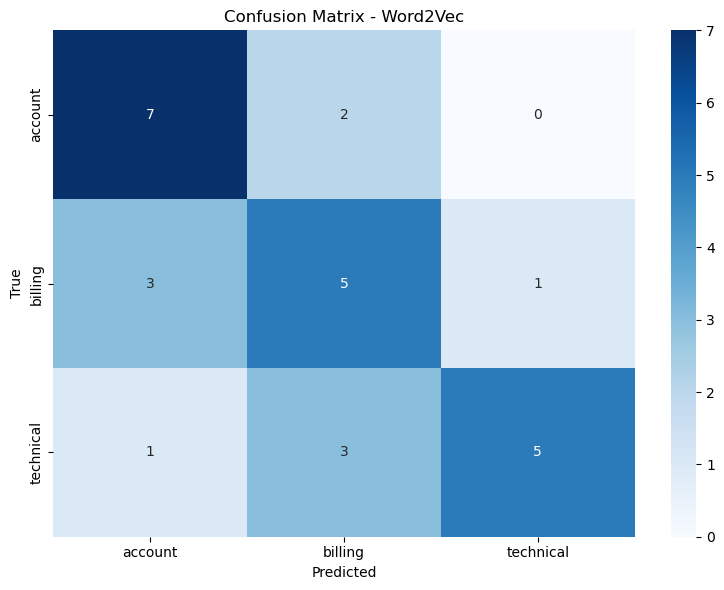


Pre-trained Embeddings Model Performance:
Accuracy: 0.8148

Classification Report:
              precision    recall  f1-score   support

     account       0.78      0.78      0.78         9
     billing       0.80      0.89      0.84         9
   technical       0.88      0.78      0.82         9

    accuracy                           0.81        27
   macro avg       0.82      0.81      0.81        27
weighted avg       0.82      0.81      0.81        27



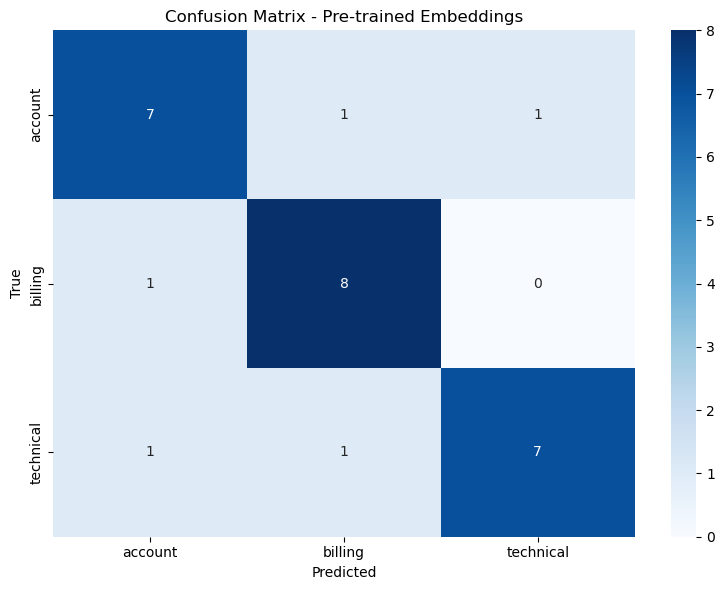

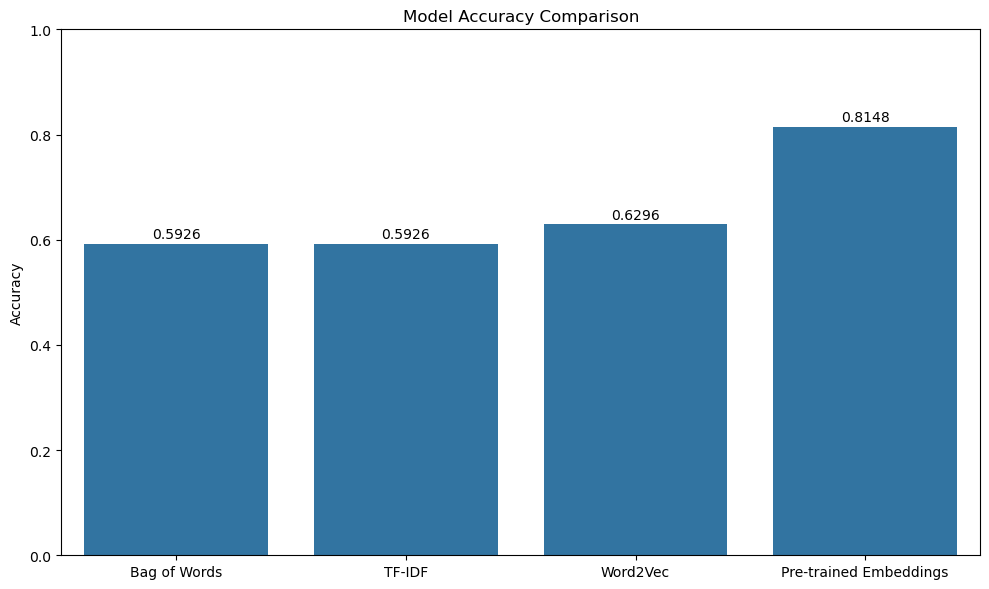

In [18]:
# Function to evaluate and display model performance
def evaluate_model(y_true, y_pred, model_name):
   """Evaluate a model and print performance metrics."""
   accuracy = accuracy_score(y_true, y_pred)
   print(f"\n{model_name} Model Performance:")
   print(f"Accuracy: {accuracy:.4f}")
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))
  
   # Create a confusion matrix
   cm = confusion_matrix(y_true, y_pred)
  
   # Plot confusion matrix as a heatmap
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=sorted(set(y_true)),
              yticklabels=sorted(set(y_true)))
   plt.title(f'Confusion Matrix - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   plt.tight_layout()
   plt.show()
  
   return accuracy


# Evaluate all models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF")
w2v_accuracy = evaluate_model(y_test, y_pred_w2v, "Word2Vec")


if pretrained_available:
   pretrained_accuracy = evaluate_model(y_test, y_pred_pretrained, "Pre-trained Embeddings")


# Compare models
models = ["Bag of Words", "TF-IDF", "Word2Vec"]
accuracies = [bow_accuracy, tfidf_accuracy, w2v_accuracy]


if pretrained_available:
   models.append("Pre-trained Embeddings")
   accuracies.append(pretrained_accuracy)


# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In this evaluation phase, we assess how well each of our models performs on the test data. We use several key metrics:

1. Accuracy: The proportion of tickets correctly classified
2. Precision: The proportion of positive identifications that were actually correct
3. Recall: The proportion of actual positives that were identified correctly
4, F1-score: The harmonic mean of precision and recall

The confusion matrix provides a detailed view of where our model succeeds and where it makes mistakes. By comparing the performance of models built with different feature representations, we can understand the trade-offs between these approaches. 

Traditional Bag-of-Words and TF-IDF models often perform surprisingly well for text classification, while word embeddings can capture more semantic nuance but might require more data to be effective. 

Not surprisingly given the size of the dataset the pre-trained word embeddings model is performing the best in terms of classification accuracy. There is however extensive hyperparameter tuning that can be done for sklearn vectorizers.

##### Step 6: Model Refinement and Optimization

Performing grid search to optimize model hyperparameters...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 3)}
Best cross-validation accuracy: 0.7346

Optimized TF-IDF Model Performance:
Accuracy: 0.7037

Classification Report:
              precision    recall  f1-score   support

     account       0.64      0.78      0.70         9
     billing       0.75      0.67      0.71         9
   technical       0.75      0.67      0.71         9

    accuracy                           0.70        27
   macro avg       0.71      0.70      0.70        27
weighted avg       0.71      0.70      0.70        27



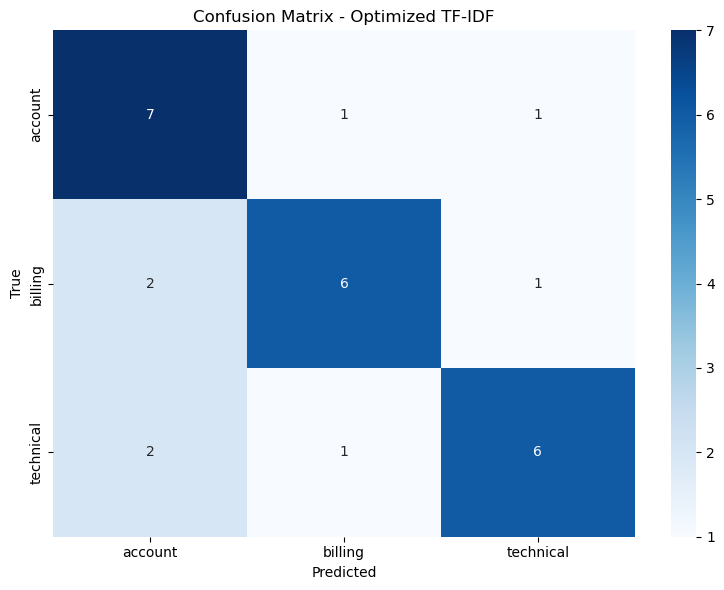

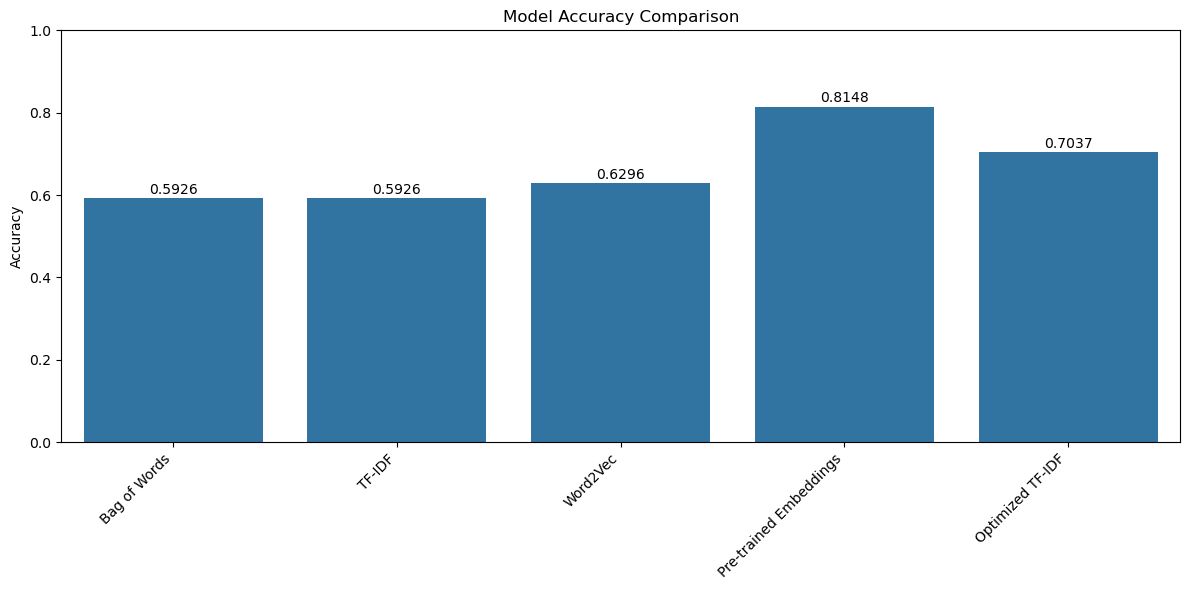

In [19]:
from sklearn.model_selection import GridSearchCV


# Create a pipeline for the TF-IDF approach
tfidf_pipeline = Pipeline([
   ('vectorizer', TfidfVectorizer(preprocessor=advanced_preprocess, lowercase=False)),
   ('classifier', MultinomialNB())
])


# Define parameter grid to search
param_grid = {
   'vectorizer__min_df': [1, 2, 3],
   'vectorizer__max_df': [0.9, 0.95, 1.0],
   'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
   'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(
   tfidf_pipeline,
   param_grid,
   cv=5,             # 5-fold cross-validation
   scoring='accuracy',
   verbose=1
)


# Fit the grid search to the data
print("Performing grid search to optimize model hyperparameters...")
grid_search.fit(X_train, y_train)


# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


# Evaluate the optimized model on test data
optimized_pipeline = grid_search.best_estimator_
y_pred_optimized = optimized_pipeline.predict(X_test)
optimized_accuracy = evaluate_model(y_test, y_pred_optimized, "Optimized TF-IDF")


# Add to our model comparison
models.append("Optimized TF-IDF")
accuracies.append(optimized_accuracy)


# Updated plot for model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()